# EQ2425 Project 1

Names:
- Chunyu Wang
- Jingwen Liu

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import os
from scipy import ndimage
print("cv2.version == ", cv2.__version__)

cv2.version ==  3.4.2


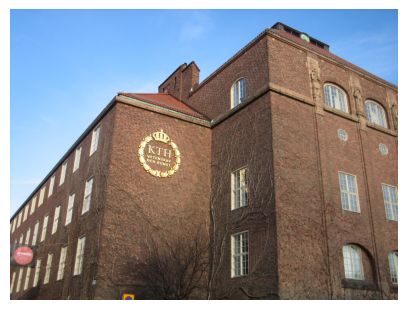

In [2]:
# Load the image.
image_path = os.path.abspath(os.getcwd() + '\\data1\\obj1_5.JPG')
image = cv2.imread(image_path)

# Print out the original figure.
plt.figure(figsize=(5, 5))
image_original_show = pltimg.imread(image_path)
plt.imshow(image_original_show)
plt.axis('off')
plt.show()

# 2.2 Robustness of Keypoint Detector

## Part A

From [OpenCV's documentation for SIFT](https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html):

- `double contrastThreshold = 0.04` is **peak threshold**
    - "The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector."
- `double edgeThreshold = 10` is **edge threshold**
    - "The threshold used to filter out edge-like features. Note that the its meaning is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less features are filtered out (more features are retained)."

From [OpenCV's documentation for SURF](https://docs.opencv.org/4.x/d5/df7/classcv_1_1xfeatures2d_1_1SURF.html):

- `double hessianThreshold = 100` controls the strength of features that the algorithm considers significant, which is **the strongest feature threshold of the SURF**.
    - "Threshold for hessian keypoint detector used in SURF."

Define the parameters in the follwoing block.

In [3]:
sift_pk_th = 0.17
sift_eg_th = 5

surf_hessian_th = 7500

sift = cv2.xfeatures2d.SIFT_create(contrastThreshold = sift_pk_th, edgeThreshold = sift_eg_th)
surf = cv2.xfeatures2d.SURF_create(hessianThreshold = surf_hessian_th)

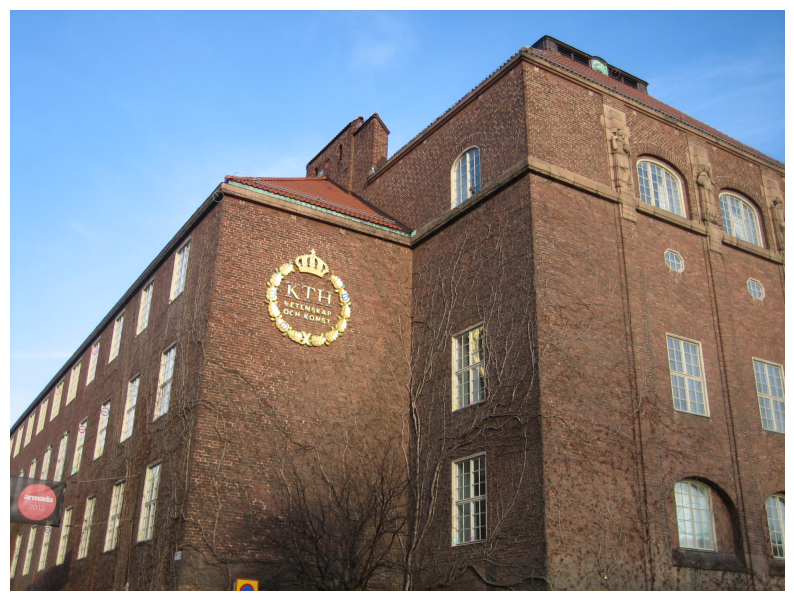

Number of keypoints detected for SIFT: 436


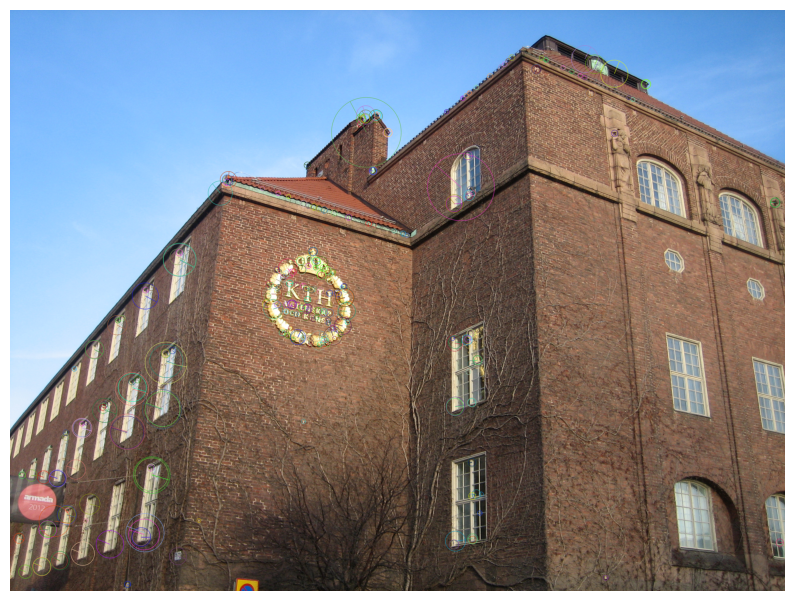

Number of keypoints detected for SURF: 351


In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

keypoints_sift, descriptors_sift = sift.detectAndCompute(gray, None)
keypoints_surf, descriptors_surf = surf.detectAndCompute(gray, None)
keypoints_image_sift = \
    cv2.drawKeypoints(image, keypoints_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
keypoints_image_surf = \
    cv2.drawKeypoints(image, keypoints_surf, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('keypoints_image_sift.jpg', keypoints_image_sift)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(keypoints_image_sift, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
print(f"Number of keypoints detected for SIFT: {len(keypoints_sift)}")

cv2.imwrite('keypoints_image_surf.jpg', keypoints_image_surf)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(keypoints_image_surf, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
print(f"Number of keypoints detected for SURF: {len(keypoints_surf)}")

From the above two figures, we noticed that when the figure only contains few hundreds of keypoints, it mostly occurs at places where **high contrasts exist**. For example, the white window frame and brown bricks poses a big contrast, and keypoints are added to the window. Similarly, the school badge is distinguished from the wall, rooftop is distinguished from the blue sky.

## Part B

In [5]:
sift_list = []
surf_list = []
sift_keypoints = []
surf_keypoints = []
sift_descriptors = []
surf_descriptors = []
Rotation_Matrix = []

for degree in np.arange(0,360,15):
    rotated_image = ndimage.rotate(image, degree, reshape=False)
    gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
    rotation_matrix = cv2.getRotationMatrix2D((gray.shape[1] // 2, gray.shape[0] // 2), degree, 1.0)

    keypoints_sift_r, descriptors_sift_r = sift.detectAndCompute(gray, None)
    keypoints_surf_r, descriptors_surf_r = surf.detectAndCompute(gray, None)
    
    sift_keypoints.append(keypoints_sift_r)
    surf_keypoints.append(keypoints_surf_r)
    sift_descriptors.append(descriptors_sift_r)
    surf_descriptors.append(descriptors_surf_r)
    Rotation_Matrix.append(rotation_matrix)

In [6]:
def Predict_new_points(keypoints, M, rotate=False):
    x, y = keypoints.pt
    if rotate is True:
        point = np.array([x, y, 1])
        transformed_point = M @ point    
    else:
        x_new = int(x * M)
        y_new = int(y * M)
        transformed_point = np.array([x_new, y_new])
    return transformed_point[:2]

def Nearby_keypoint(transformed_point, sift_surf_keypoints_transformed):
    x_prime, y_prime = transformed_point
    
    for kp in sift_surf_keypoints_transformed:
        x0, y0 = kp.pt
        if abs(x0 - x_prime) <= 2 and abs(y0 - y_prime) <= 2:
            return True
    return False

def ComRep(keypoints_original, keypoints_transformed, M, rotate=False):
    matched_keypoints = 0

    for kp in keypoints_original:
        kp_predict = Predict_new_points(kp, M, rotate)
        if Nearby_keypoint(kp_predict, keypoints_transformed):
            matched_keypoints += 1

    return matched_keypoints / len(keypoints_original)

sift matches: [1.0, 0.8532110091743119, 0.7958715596330275, 0.7752293577981652, 0.7568807339449541, 0.8073394495412844, 0.8853211009174312, 0.8188073394495413, 0.8463302752293578, 0.8532110091743119, 0.8325688073394495, 0.8692660550458715, 0.9380733944954128, 0.8256880733944955, 0.805045871559633, 0.8096330275229358, 0.7660550458715596, 0.8096330275229358, 0.8784403669724771, 0.8532110091743119, 0.8623853211009175, 0.8532110091743119, 0.8463302752293578, 0.8555045871559633]
surf matches: [1.0, 0.7578347578347578, 0.6695156695156695, 0.5925925925925926, 0.5954415954415955, 0.6552706552706553, 0.8660968660968661, 0.7606837606837606, 0.6552706552706553, 0.6153846153846154, 0.6125356125356125, 0.698005698005698, 1.0, 0.7350427350427351, 0.6011396011396012, 0.5527065527065527, 0.5868945868945868, 0.6609686609686609, 0.8660968660968661, 0.7606837606837606, 0.717948717948718, 0.6609686609686609, 0.6723646723646723, 0.7350427350427351]


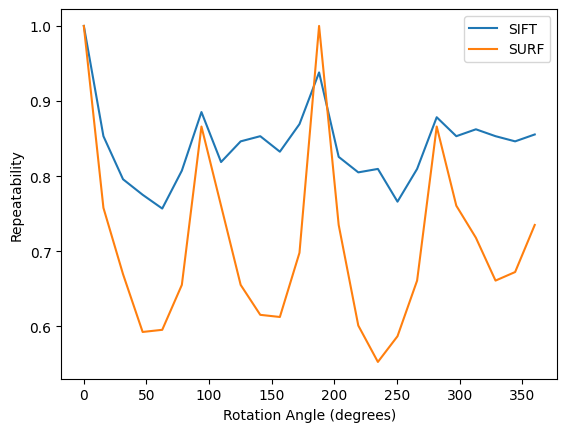

In [7]:
good_sift = []
good_surf = []

for kp_sift, kp_surf, m in zip(sift_keypoints, surf_keypoints, Rotation_Matrix):
    good_sift.append(ComRep(keypoints_sift, kp_sift, m, True))
    good_surf.append(ComRep(keypoints_surf, kp_surf, m, True))
    
print(f"sift matches: {good_sift}")
print(f"surf matches: {good_surf}")

x = np.linspace(0, 15*len(good_sift), num=len(good_sift))
plt.plot(x,good_sift)
plt.plot(x,good_surf)
plt.xlabel("Rotation Angle (degrees)")
plt.ylabel("Repeatability")
plt.legend(["SIFT","SURF"])
plt.savefig("Rotation_vs_repeatability.jpg")
plt.show()

SIFT is more robust to rotations, and performs better than SURF.

## Part C

In [8]:
def resize_image(image, scaling_factor):
    height, width = image.shape[:2]

    width = int(width * scaling_factor)
    height = int(height * scaling_factor)

    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

    return resized_image

In [9]:
sift_list = []
surf_list = []
sift_keypoints = []
surf_keypoints = []
sift_descriptors = []
surf_descriptors = []
M = []

for i in range(0, 9):
    M.append(pow(1.2, i))

for m in M:
    scaled_image = resize_image(image, m)
    gray = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2GRAY)

    keypoints_sift_r, descriptors_sift_r = sift.detectAndCompute(gray, None)
    keypoints_surf_r, descriptors_surf_r = surf.detectAndCompute(gray, None)
    
    sift_keypoints.append(keypoints_sift_r)
    surf_keypoints.append(keypoints_surf_r)
    sift_descriptors.append(descriptors_sift_r)
    surf_descriptors.append(descriptors_surf_r)

sift matches: [1.0, 0.6238532110091743, 0.5848623853211009, 0.5986238532110092, 0.5298165137614679, 0.5435779816513762, 0.5160550458715596, 0.49311926605504586, 0.44724770642201833]
surf matches: [1.0, 0.8205128205128205, 0.8433048433048433, 0.7549857549857549, 0.7407407407407407, 0.5612535612535613, 0.5868945868945868, 0.4188034188034188, 0.2022792022792023]


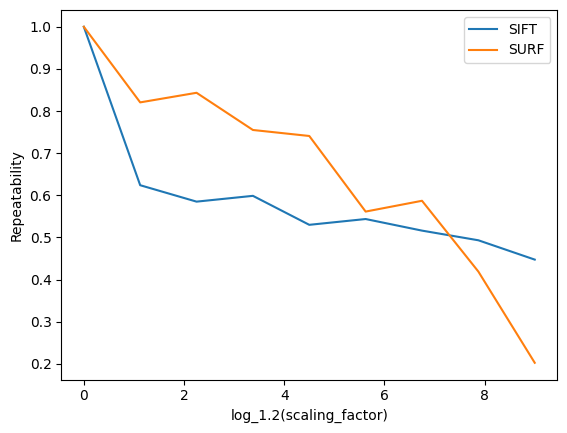

In [10]:
good_sift = []
good_surf = []

for kp_sift, kp_surf, m in zip(sift_keypoints, surf_keypoints, M):
    good_sift.append(ComRep(keypoints_sift, kp_sift, m, False))
    good_surf.append(ComRep(keypoints_surf, kp_surf, m, False))

print(f"sift matches: {good_sift}")
print(f"surf matches: {good_surf}")

x = np.linspace(0, len(good_sift), num=len(good_sift))
plt.plot(x,good_sift)
plt.plot(x,good_surf)
plt.xlabel("log_1.2(scaling_factor)")
plt.ylabel("Repeatability")
plt.legend(["SIFT","SURF"])
plt.savefig("Scaling_vs_repeatability.jpg")
plt.show()

SIFT repeatability drops sharply when the image size inceases, but it is more robust to scaling as scaling factor grows larger. SIFT performs better than SIFT when the scaling factor increased by a little, but is less robust when the scaling factor continues to increase.

# 3. Image Feature Matching

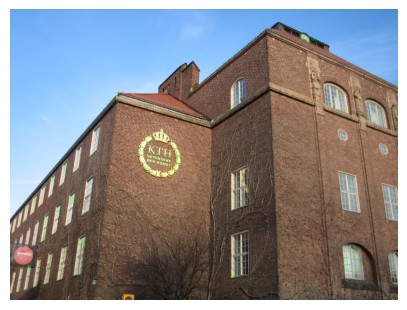

Number of keypoints detected for SIFT: 436


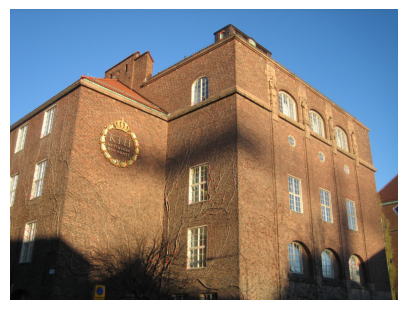

Number of keypoints detected for SIFT: 645


In [11]:
## 3.(a)
image_path1 = os.path.abspath(os.getcwd() + '\\data1\\obj1_5.JPG')
image1 = cv2.imread(image_path1)
image_path2 = os.path.abspath(os.getcwd() + '\\data1\\obj1_t1.JPG')
image2 = cv2.imread(image_path2)

sift_pk_th = 0.17
sift_eg_th = 5

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
sift1 = cv2.xfeatures2d.SIFT_create(contrastThreshold = sift_pk_th, edgeThreshold = sift_eg_th)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
sift2 = cv2.xfeatures2d.SIFT_create(contrastThreshold = sift_pk_th, edgeThreshold = sift_eg_th)

keypoints_sift1, descriptors_sift1 = sift.detectAndCompute(gray1, None)
keypoints_sift2, descriptors_sift2 = sift.detectAndCompute(gray2, None)

keypoints_image_sift1 = \
    cv2.drawKeypoints(image1, keypoints_sift1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,color=(0, 255, 0))
keypoints_image_sift2 = \
    cv2.drawKeypoints(image2, keypoints_sift2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,color=(0, 0, 255))

#cv2.imwrite('keypoints_image1_sift.jpg', keypoints_image_sift1)
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(keypoints_image_sift1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
print(f"Number of keypoints detected for SIFT: {len(keypoints_sift1)}")

#cv2.imwrite('keypoints_image2_sift.jpg', keypoints_image_sift2)
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(keypoints_image_sift2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
print(f"Number of keypoints detected for SIFT: {len(keypoints_sift2)}")

FT threshold: 150, number of matches: 27
FT threshold: 170, number of matches: 42
FT threshold: 190, number of matches: 65


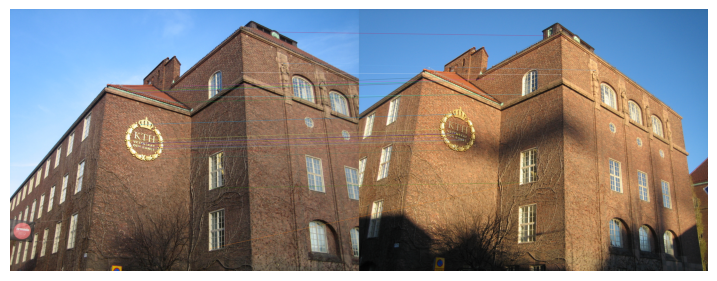

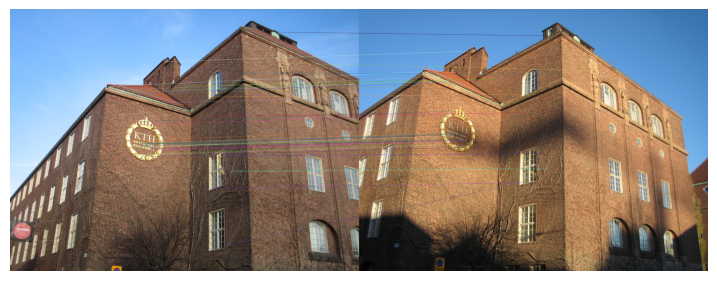

In [12]:
## 3.(b) ”fixed threshold” matching algorithm
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_sift1, descriptors_sift2,k=2)

for threshold in [150,170,190]:
    FT_matches = [[d] for d ,_ in matches if d.distance < threshold]
    img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matched_image = cv2.drawMatchesKnn(img1, keypoints_sift1, img2, keypoints_sift2, FT_matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #cv2.imwrite('sift_FTmatch_{}.jpg'.format(threshold), matched_image)
    plt.figure(figsize=(9, 6))
    plt.imshow(matched_image)
    plt.axis('off')
    print(f'FT threshold: {threshold}, number of matches: {len(FT_matches)}')

(-0.5, 5183.5, 1943.5, -0.5)

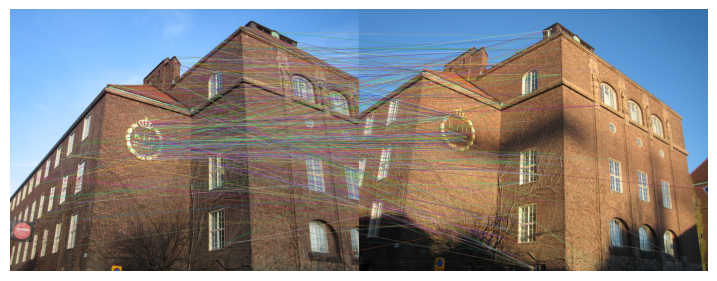

In [13]:
## 3.(c) ”nearest neighbor” matching algorithm
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_sift1, descriptors_sift2,k=2)

good_matches = []
for m,_ in matches:
    good_matches.append(m)

img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
matched_image = cv2.drawMatches(img1, keypoints_sift1, img2, keypoints_sift2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(9, 6))
plt.imshow(matched_image)
plt.axis('off')
#cv2.imwrite('sift_NNmatch.jpg', matched_image)

(-0.5, 5183.5, 1943.5, -0.5)

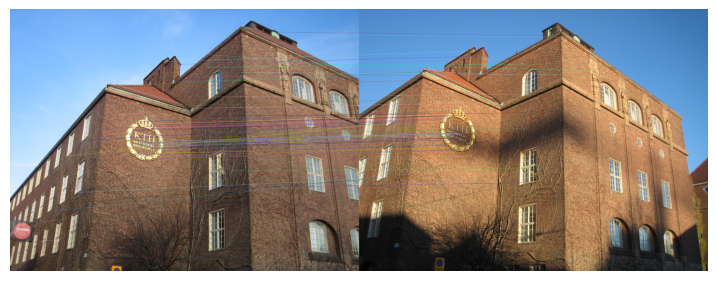

In [14]:
## 3.(d) ”nearest neighbor distance ratio” matching algorithm
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_sift1, descriptors_sift2,k=2)

good_matches = []
ratio_thresh = 0.75

for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
matched_image = cv2.drawMatches(img1, keypoints_sift1, img2, keypoints_sift2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(9, 6))
plt.imshow(matched_image)
plt.axis('off')
# cv2.imwrite('sift_NNDRmatch.jpg', matched_image)

(-0.5, 5183.5, 1943.5, -0.5)

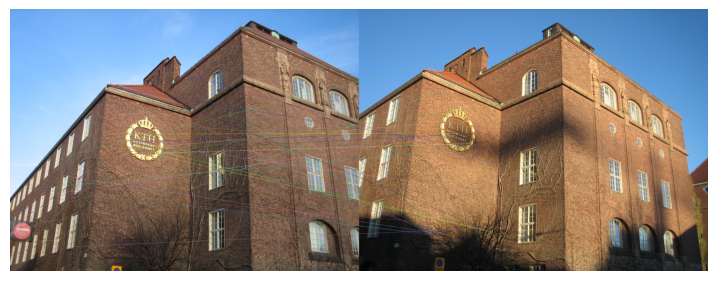

In [15]:
## 3.(e) SURF: ”nearest neighbor distance ratio” matching algorithm
surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 7500)
keypoints_surf1, descriptors_surf1 = surf.detectAndCompute(gray1, None)
keypoints_surf2, descriptors_surf2 = surf.detectAndCompute(gray2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_surf1, descriptors_surf2,k=2)

good_matches = []
ratio_thresh = 0.75

for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
matched_image = cv2.drawMatches(img1, keypoints_sift1, img2, keypoints_sift2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(9, 6))
plt.imshow(matched_image)
plt.axis('off')
# cv2.imwrite('surf_NNDRmatch.jpg', matched_image)